# Hochschule Bonn-Rhein-Sieg

# Machine Learning

# Reinforcement Learning Assignment

Before you start working on this assignment, please:
* set up the [OpenAI gym library](https://gym.openai.com), which is a Python library that defines various benchmarking environments in which reinforcement learning agents can be trained. Installation instructions for the library can be found [here](https://gym.openai.com/docs/#installation)
* go through the ["Getting Started With Gym" tutorial](https://gym.openai.com/docs/#getting-started-with-gym) so that you can use the library effectively during the assignment

In [1]:
import numpy as np
import gym
import time
import math

from matplotlib import pyplot as plt

np.set_printoptions(precision=4, suppress=True)

## Q-Learning

Your task in this assignment is, in principle, rather simple: You need to implement the Q-learning algorithm for solving the cart-pole problem that we discussed in the reinforcement learning lecture.

As you might remember from the lecture, the observation space of the cart-pole system consists of:
1. the cart's $x$ position on the track
2. the cart's linear velocity $\dot{x}$ along the track
3. the pole's angle $\theta$ with respect to the vertical axis
4. the pole's angular velocity $\dot{\theta}$

The action space of the system is discrete - the pole can move either to the left or to the right with a constant velocity.


The cart-pole environment provided in OpenAI gym is episodic, such that an episode ends if the pole (i) falls beyond a certain angle (the agent has failed in this case) or (ii) doesn't fall for 200 consecutive steps (the agent has succeeded in this case).

### Q-Function Learning [80 points]

Your main task is to implement the function `train_policy` below, which takes the cart-pole environment provided in OpenAI gym and learns the values of the Q-function $Q(s,a)$ so that the cart-pole problem can be solved.

#### State discretisation

We particularly want to implement a discrete version of Q-learning, namely the Q-function $Q(s,a)$ should be learned for a discretised version of the state space. This means that you need to choose a discretisation of the state space variables so that you can then learn a tabular version of $Q(s,a)$ for all possible combinations of $s$ and $a$.

You don't need to use all four state variables in your Q-function if some don't seem to contribute to the performance of the agent. This is something you will need to experiment with in your implementation.

#### Action selection during training

How you select actions during training is another aspect that you need to choose and experiment with. Remember that Q-learning is an off-policy learning algorithm, so it doesn't always choose the best action according to the current Q-values. A commonly used strategy is to use an $\epsilon$-greedy policy during learning, according to which a greedy action (the one with the highest Q-value) is selected most of the time, but a random action is chosen with a probability $p$, where $p$ starts large at the beginning and decreases according to some schedule during the training process.

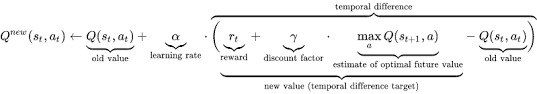

In [2]:
np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])

def discretize(state: np.array) -> np.array:
    discrete_state = state / np_array_win_size + np.array([15,10,1,10])
    return tuple(discrete_state.astype(np.int))


def train_policy(env,
                 *, 
                 n_episodes: int = 60000, 
                 learning_rate: float = 0.1, 
                 discount_factor: float = 0.95,
                 size = [30, 30, 50, 50],
                 epsilon_decay_value: float = 0.99995,
                 plot: bool = False
            ) -> np.ndarray:
    """Trains a policy for the given environment using tabular Q-learning.

    Keyword arguments:
    env -- OpenAI gym environment
    n_episodes: int -- how many episodes to train the agent for
    learning_rate: float
    discount_factor: float
    weights: np.array -- weights for cart pos, cart vel, pole angle, pole vel (higher is more important)
    epsilon_decay_value: float

    Returns:
    Q -- a multidimensional numpy array representing the Q function Q(s,a)

    """
        
    total_time = 0
    total_reward = 0
    prior_reward = 0
    count_random_action = 0
    count_coordinatied_actions = 0

    epsilon = 1
    rewards = []
    epsilons = []
    counts_coordinated = []
    counts_random = []
    

    Q = np.random.uniform(low=0, high=1, size=(size + [env.action_space.n]))
    
    for episode in range(n_episodes + 1): 
        time_start = time.time() 
        state_start = env.reset()
        discrete_state = discretize(state_start) 
        done = False

        episode_reward = 0 
        
        
        if episode % 2000 == 0: 
            print("episode: " + str(episode))
            
        while not done: 
            if np.random.random() > epsilon:
                action = np.argmax(Q[discrete_state])
                count_coordinatied_actions += 1
            else:
                action = np.random.randint(0, env.action_space.n)
                count_random_action += 1
                
            
            new_state, reward, done, _ = env.step(action)

            episode_reward += reward
            new_discrete_state = discretize(new_state)
               
            if not done:
                max_future_Q = np.max(Q[new_discrete_state])
                current_Q = Q[discrete_state + (action, )]
                new_Q = (1 - learning_rate) * current_Q + learning_rate * (reward + discount_factor * max_future_Q)
                Q[discrete_state + (action,)] = new_Q
                

            discrete_state = new_discrete_state
            

        if epsilon > 0.05:
            if episode_reward > prior_reward and episode > 10000:
                epsilon = math.pow(epsilon_decay_value, episode - 10000)

        time_now = time.time() 
        episode_total = time_now - time_start 
        total_time = total_time + episode_total
        prior_reward = episode_reward
    

        rewards.append(episode_reward)
        epsilons.append(epsilon)
        counts_coordinated.append(count_coordinatied_actions)
        counts_random.append(count_random_action)
        
        
        total_reward += episode_reward

        if episode % 1000 == 0:
            mean = total_time / 1000
            print(f"mean time alive: {mean}")
            total_time = 0

            mean_reward = total_reward / 1000
            print(f"mean last 1000 episodes reward: {mean_reward}")
            total_reward = 0
            
#     if plot:       
#         x_axis = list(range(n_episodes + 1))
#         plt.scatter(x_axis, rewards)
        
    print(f"finished training for {n_episodes} episodes, current reward: {mean_reward}")
    return Q


Please run the following cell to execute your Q-function implementation. The learned Q-values will be used below for testing the agent. Note that learning may take several minutes. You are allowed to change the number of learning episodes to fit your implementation.

In [3]:
env = gym.make("CartPole-v1")
try:
    Q = train_policy(env)
except Exception as e:
    env.close()
    raise e
    
env.close()

episode: 0
mean time alive: 1.6558170318603516e-06
mean last 1000 episodes reward: 0.025
mean time alive: 0.000608274221420288
mean last 1000 episodes reward: 22.786
episode: 2000
mean time alive: 0.0005851171016693115
mean last 1000 episodes reward: 21.876
mean time alive: 0.0006217844486236572
mean last 1000 episodes reward: 22.955
episode: 4000
mean time alive: 0.0005868489742279052
mean last 1000 episodes reward: 21.644
mean time alive: 0.0006161396503448486
mean last 1000 episodes reward: 22.753
episode: 6000
mean time alive: 0.0006102466583251953
mean last 1000 episodes reward: 22.209
mean time alive: 0.0006026384830474853
mean last 1000 episodes reward: 21.874
episode: 8000
mean time alive: 0.0005910308361053467
mean last 1000 episodes reward: 21.608
mean time alive: 0.0005812475681304932
mean last 1000 episodes reward: 21.604
episode: 10000
mean time alive: 0.0006064765453338623
mean last 1000 episodes reward: 22.251
mean time alive: 0.0006584277153015137
mean last 1000 episode

### Agent Testing [20 points]

Now that you have learned a Q-function for the cart-pole problem, you need to test your implementation. For this, please implement the function `test_policy`, which runs the agent for a given number of test episodes using the learned Q-values and returns the average return over the test episodes.

You can consider the cart-pole problem solved if your average return is $\geq 195$, which means that your agent is able to survive until the end of each episode most of the time.

If you notice that the average return is lower than expected, there might be different issues with the implementation, for instance:
* the number of training episodes might be low
* the action selection during training may be inappropriate (try experimenting with different schedules for your epsilon-greedy policy)
* your state space discretisation may be inappropriate (also, the more fine-grained the discretisation is, the more training episodes you will need)

You may need to experiment with all of these until you successfully train your agent.

Good luck!

In [4]:
def test_policy(env, Q: np.ndarray, test_episodes: int) -> float:
    """Test a policy extracted from a learned Q-function on the given environment.
    The policy is tested for a given number of episodes.

    Keyword arguments:
    env -- OpenAI gym environment
    Q: np.ndarray -- a multidimensional numpy array representing the Q function Q(s,a)
    test_episodes: int -- number of episodes for testing the learned policy

    Returns:
    avg_return: float -- the average return over the test episodes

    """  
    total_reward = 0
    for episode in range(test_episodes):
        time_start = time.time() 
        state_start = env.reset()
        done = False
        episode_reward = 0  
        discrete_state = discretize(state_start) 
        
        while not done: 
            action = np.argmax(Q[discrete_state])
            new_state, reward, done, _ = env.step(action)
            discrete_state = discretize(new_state)
            episode_reward += reward  
            env.render()
            
        total_reward += episode_reward

    env.close()

    return total_reward / test_episodes

In [5]:
test_episodes = 10

print('Testing policy for {0} episodes...'.format(test_episodes))
avg_return = test_policy(env, Q, test_episodes)
env.close()
print('Average test return =', avg_return)

Testing policy for 10 episodes...
Average test return = 374.4
